#RFM-Анализ данных Маркета

##1. Загрузка данных, EDA

In [6]:
import pandas as pd
import time
import datetime
import numpy as np
import seaborn

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [7]:
#подключаем графику
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
data=pd.read_csv('./rfm.tsv',header=None, delimiter='\t',names=['timestamp','user_id','url' ,'geo_id','category' ,'price'])

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [396]:
print ( "Общее число записей %d" % data.size)
print ( "Число уникальных пользователей %d" % data['user_id'].unique().size)
pay_users=(data[data.url=='click'])['user_id'].unique().size
m=data['user_id'].unique().size
print ( ("Конверсия в клики %.2f%%") % (pay_users/float(m)*100) )
print ( "Total revenue %s " % (data[data.url=='click'])['price'].sum() )
s=(data[data.url=='click'])['price'].sum()
ARPPU=float(s)/m # будем использовать для расчёта эффекта
print ( "ARPPU %.3f " % (ARPPU) )

Общее число записей 60042882
Число уникальных пользователей 299208
Конверсия в клики 18.47%
Total revenue 10256466.0 
ARPPU 34.279 


In [46]:
data.head()

,timestamp,user_id,url,geo_id,category,price
0,1380052543,00002ad98ae4290672431d702c211b4a,/_c/YwrVrj_29IVZDmKxglT53wo7Pk8.html,10000,NaN,NaN
1,1375703582,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=y5fc6079b758f5a4e3646a8...,10000,NaN,NaN
2,1374479873,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN
3,1374479892,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN
4,1374480337,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN


##2. Разбиваем данные по измерениям для RFM-анализа 

In [230]:
d_monetary=data.groupby('user_id')['price'].sum()

In [236]:
d_recency=(data[data['url']=='click']).groupby('user_id')['timestamp'].max() # вычисляем дату последнего запроса от пользователя

In [237]:
current_time=int(time.time())

In [238]:
d_recency=current_time-d_recency # считаем recency по каждому пользователю

In [239]:
d_views=data.groupby('user_id')['timestamp'].count() # число просмотров

In [240]:
d_frequency=data.groupby('user_id')['price'].count() # число переходов

## 3. ABC-анализ регионов и товарных категорий

In [350]:
clicks=data[data['url']=='click'][['user_id','geo_id','category','price']] # детальная статистика по кликам

In [149]:
# ABC-анализ по категориям
cat_count = pd.DataFrame(clicks.groupby('category')['price'].mean(),index=clicks.groupby('category')['price'].mean().index)
cat_price = pd.DataFrame(clicks.groupby('category')['price'].count(),index=clicks.groupby('category')['price'].count().index)
cat_ABC_stat = cat_count.join(cat_price,how='inner',rsuffix='_r',lsuffix='_l')
cat_ABC_stat.columns=['num','price']
cat_ABC_stat['turnover']=cat_ABC_stat.num*cat_ABC_stat.price
# сортируем по обороту, выводим
cat_ABC=(cat_ABC_stat['turnover'].sort_values(ascending=False)).cumsum()/cat_ABC_stat['turnover'].sum()*100
print cat_ABC.head()
print "Вывод: {:.3g}% товарных категорий генерируют 80% оборота".format(cat_ABC[cat_ABC<=80].size/float(cat_ABC.size)*100)

category
91491      15.482331
6427100    20.944232
90639      25.353236
90490      29.337347
91148      32.514328
Name: turnover, dtype: float64
Вывод: 7.65% товарных категорий генерируют 80% оборота


In [150]:
# ABC-анализ по регионам
geo_count = pd.DataFrame(clicks.groupby('geo_id')['price'].mean(),index=clicks.groupby('geo_id')['price'].mean().index)
geo_price = pd.DataFrame(clicks.groupby('geo_id')['price'].count(),index=clicks.groupby('geo_id')['price'].count().index)
geo_ABC_stat = geo_count.join(geo_price,how='inner',rsuffix='_r',lsuffix='_l')
geo_ABC_stat.columns=['num','price']
geo_ABC_stat['turnover']=geo_ABC_stat.num*geo_ABC_stat.price
# сортируем по обороту, выводим
geo_ABC=(geo_ABC_stat['turnover'].sort_values(ascending=False)).cumsum()/geo_ABC_stat['turnover'].sum()*100
print geo_ABC.head(5)
print "Вывод: {:.3g}% регионов генерируют 80% оборота".format(geo_ABC[geo_ABC<=80].size/float(geo_ABC.size)*100)

geo_id
213    56.912761
2      69.140170
54     71.517480
47     73.196362
0      74.481620
Name: turnover, dtype: float64
Вывод: 1.1% регионов генерируют 80% оборота


##4. RFM-анализ покупателей

###4.1 Recency пользователей

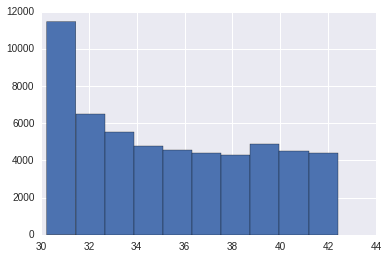

In [241]:
p_recency=np.append(0,np.percentile(d_recency.values,[20,40,60,80,100]))
(d_recency/(60*60*24*30)).hist()

###4.2 Monetary пользователей

Доля платящих пользователей 0.185


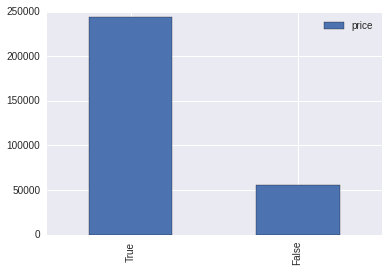

In [16]:
# проверим, сколько пропущенных значений
pd.isnull(d_monetary).value_counts().plot(kind='bar',stacked=True, legend=True)
print("Доля платящих пользователей {:.3g}".format(float(pd.isnull(d_monetary).value_counts()[False])/
                          pd.isnull(d_monetary).value_counts().sum()))

In [243]:
nd_monetary=d_monetary.fillna(0) # заполняем revenue пользователей, которые не переходили в магазин

In [244]:
# при расчёте перцентилей не учитываем неплатящих пользователей (т.к. их более 80%)
p_monetary=np.append(0,np.percentile(nd_monetary[nd_monetary>0].values,[20,40,60,80,100]))

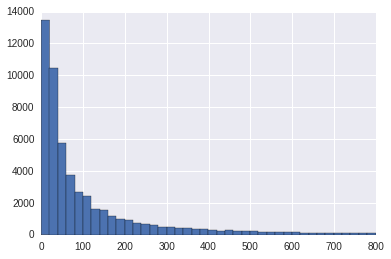

In [245]:
(d_monetary[d_monetary<800]).hist(bins=40)

In [ ]:
print d_monetary.sort_values(ascending=False).cumsum()

###4.3 Frequency пользователей

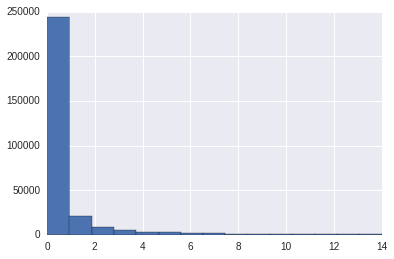

In [250]:
# заполняем пропуски нулями и расчитываем  перцентили
nd_frequency=d_frequency.fillna(0) # заполняем revenue пользователей, которые не переходили в магазин
p_frequency=np.append(0,np.percentile(nd_frequency[nd_frequency>0].values,[20,40,60,80,100]))
(nd_frequency[nd_frequency<15]).hist(bins=15)

###5. Сегментация

In [20]:
def RFM_segmentation(ts, q):
    '''
    Преобразуем переданный TimeSeries в DataFrame - добавляем столбец с сегментом
    '''
    #добавить проверку на размер вектора квантилей
    df=pd.DataFrame(ts,index=ts.index) #создаём датафрейм
    df['group']=float(NaN) # добавляем столбцец, где будут храниться сегменты
    for i in xrange(1,q.size):
       df.iloc[:,1][(df.iloc[:,0]>=q[i-1]) & (df.iloc[:,0]<=q[i]) ]=i
    return df

In [252]:
monetary=RFM_segmentation(nd_monetary, p_monetary)
recency=RFM_segmentation(d_recency, p_recency)
recency['group']=(6-recency['group'])# для групп меняем порядок, самые "свежие" в пятой группе
frequency=RFM_segmentation(nd_frequency, p_frequency)

/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### 5.1 Итоговая сегментация в одном DataFrame

In [253]:
RFM = (recency.join(frequency, how='outer', lsuffix='_1', rsuffix='_2')).join(
                            monetary, how='outer', rsuffix='_3')

In [254]:
print RFM.columns
RFM.columns = ['recency', 'g1', 'frequency', 'g2', 'monetary', 'g3']
print RFM.columns

Index([u'timestamp', u'group_1', u'price', u'group_2', u'price_3', u'group'], dtype='object')
Index([u'recency', u'g1', u'frequency', u'g2', u'monetary', u'g3'], dtype='object')


####5.2 Выделяем RFM-сегменты

In [255]:
dist_RFM=RFM.groupby(['g1','g2','g3'])['recency'].count() # сколько попало в каждую группу

In [256]:
print dist_RFM.head()

g1  g2  g3
1   2   1     2669
        2      957
        3      698
        4      366
        5       87
Name: recency, dtype: int64


###5.3 Визулизация сегментов

In [27]:
from matplotlib import cm
col_map = cm.get_cmap('rainbow')

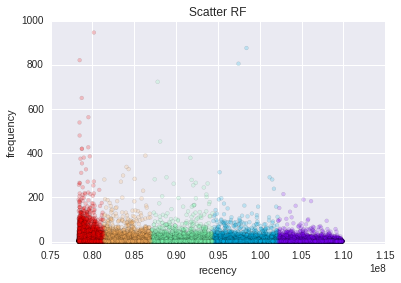

In [258]:
s1=recency.join(frequency, how='outer', lsuffix='_1', rsuffix='_2')#.plot(kind='scatter', x='timestamp', y='price')
pyplot.clf()
pyplot.xlabel('recency')
pyplot.ylabel('frequency')
pyplot.title('Scatter RF')
pyplot.ylim( (-10, 1000) )
pyplot.scatter(s1['timestamp'], s1['price'], s=15, c=s1['group_1'], marker='o', cmap=col_map, alpha=0.2)

In [229]:
recency.head()

,timestamp,group
user_id,,
00002ad98ae4290672431d702c211b4a,86658549,3
00003cb9076039f584a12c2036fd3602,80481296,5
000065938a8c02438551bef260a5ded0,102739436,1
000098543e00d361552ab956ec525772,94581885,2
0000d4b93e501f038977d4ae8fb7693b,83476521,4


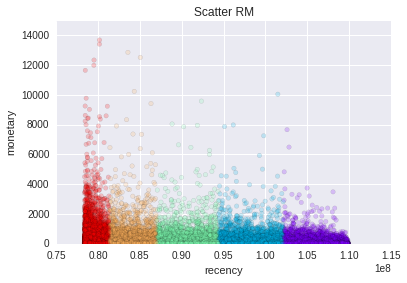

In [259]:
s2=recency.join(monetary, how='outer', lsuffix='_1', rsuffix='_2')
pyplot.clf()
pyplot.xlabel('recency')
pyplot.ylabel('monetary')
pyplot.title('Scatter RM')
pyplot.ylim( (-10, 15000) )
pyplot.scatter(s2['timestamp'], s2['price'], s=20, c=s2['group_1'], marker='o', cmap=col_map, alpha=0.2)

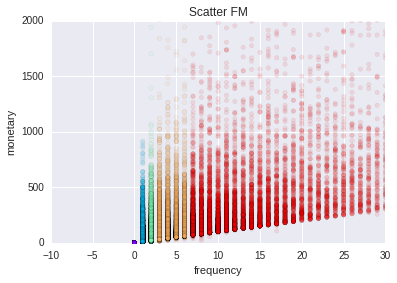

In [260]:
s3=frequency.join(monetary, how='outer', lsuffix='_1', rsuffix='_2')
pyplot.clf()
pyplot.xlabel('frequency')
pyplot.ylabel('monetary')
pyplot.title('Scatter FM')
pyplot.xlim( (-10, 30) )
pyplot.ylim( (-10, 2000) )
pyplot.scatter(s3['price_1'], s3['price_2'], s=20, c=s3['group_1'], marker='o', cmap=col_map, alpha=0.1)

###6. Формируем рекомендации

#### "Вспомнить всё"

In [356]:
''' сегменты 155 и 255
Приносили большую прибыль, но давно ничего не покупали - кандидаты на отток.
Решение - "напомнить" им о Маркете с помощью email-рассылки
'''
m1=( frequency[frequency['group']==5].join(
                                monetary[monetary['group']==5], how='inner', lsuffix='_1', rsuffix='_2')).join(
                                recency[(recency['group']==1) | (recency['group']==2)], how='inner', lsuffix='_1', rsuffix='_2')
                                    .index.unique().size
# строим выборку из clicks
n1=(clicks[ clicks['user_id'].isin(( frequency[frequency['group']==5].join(
                                monetary[monetary['group']==5], how='inner', lsuffix='_1', rsuffix='_2')).join(
                                recency[(recency['group']==1) | (recency['group']==2)], how='inner', lsuffix='_1', rsuffix='_2')
                                   .index.unique())
        & clicks['geo_id'].isin(geo_ABC[geo_ABC<=80].index) ] )['user_id'].unique().size
print (("Пользователей в группах <155, 255>: %d, из них участники компании %d, размер эффекта %.2f руб.")%(m1,n1,n1*ARPPU))

Пользователей в группах <155, 255>: 2026, из них участники компании 1706, размер эффекта 58479.49 руб.


####"Горячие деньки"

In [394]:
''' сегменты [4,5][1,2,3][4,5]
Покупают редко, но на большие суммы. Решение - up-sale
'''
m2=( frequency[(frequency['group']==1) | (frequency['group']==2) |(frequency['group']==3)].join(
        monetary[(monetary['group']==4) | (monetary['group']==5)], how='inner', lsuffix='_1', rsuffix='_2')).join(
        recency[(recency['group']==4) | (recency['group']==5)], how='inner', lsuffix='_1', rsuffix='_2').index.unique().size
# строим выборку из clicks
n2=(clicks[ clicks['user_id'].isin(( frequency[(frequency['group']==1) | (frequency['group']==2) |(frequency['group']==3)].join(
        monetary[(monetary['group']==4) | (monetary['group']==5)], how='inner', lsuffix='_1', rsuffix='_2')).join(
        recency[(recency['group']==4) | (recency['group']==5)], how='inner', lsuffix='_1', rsuffix='_2').index.unique())
        & clicks['geo_id'].isin(geo_ABC[geo_ABC<=80].index) ] )['user_id'].unique().size
print (("Пользователей в группах <515, 525, 535, 415, 425, 435, 514, 524, 534>: %d, из них участники компании %d, размер эффекта %.2f руб.")%(m2,n2,n2*ARPPU))

Пользователей в группах <515, 525, 535, 415, 425, 435, 514, 524, 534>: 1950, из них участники компании 1628, размер эффекта 55805.75 руб.


In [395]:
''' сегменты [4,5][4,5][1,2,3]
Покупают  часто, но на небольшие суммы. Решение -  cross-sale.
Выбор товаров - исходя из ABC анализа.
'''
m3=( frequency[(frequency['group']==4) | (frequency['group']==5)].join(
        monetary[(monetary['group']==1) | (monetary['group']==2) | (monetary['group']==3)], how='inner', lsuffix='_1', rsuffix='_2')).join(
        recency[(recency['group']==4) | (recency['group']==5)], how='inner', lsuffix='_1', rsuffix='_2').index.unique().size
# строим выборку из clicks
n3=(clicks[ clicks['user_id'].isin(( frequency[(frequency['group']==4) | (frequency['group']==5)].join(
        monetary[(monetary['group']==1) | (monetary['group']==2) | (monetary['group']==3)], how='inner', lsuffix='_1', rsuffix='_2')).join(
        recency[(recency['group']==4) | (recency['group']==5)], how='inner', lsuffix='_1', rsuffix='_2').index.unique())
        & clicks['geo_id'].isin(geo_ABC[geo_ABC<=80].index) ] )['user_id'].unique().size
print (("Пользователей в группах <451, 452, 453, 441, 442, 443, 551, 552, 553>: %d, из них участники компании %d, размер эффекта %.2f руб.")%(m3,n3,n3*ARPPU))

Пользователей в группах <451, 452, 453, 441, 442, 443, 551, 552, 553>: 2942, из них участники компании 1840, размер эффекта 63072.84 руб.
